# Optimize Hyperparameters for Different Methods

:::{warning}
This notebook represents historical work to determine optimum hyperparameters. Not currently working.
:::

In [5]:
import pandas as pd
import os
import csv
import io
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import seaborn as sns
from matplotlib.dates import DateFormatter

import yaml

from sklearn.impute import KNNImputer
import sklearn.impute
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

from imputeMF import imputeMF

from statsmodels.imputation.mice import MICEData

In [ ]:
variable = 'temperature_degrees'
df = pd.read_csv('data.csv', parse_dates=True, index_col=0)

# Define the cutoff date
cutoff_date = "2020-09-01"

# Select rows past the cutoff date
df = df[df.index >=  pd.Timestamp(cutoff_date)]

# Define the cutoff date
cutoff_date = "2024-08-31"

# Select rows past the cutoff date
df = df[df.index <=  pd.Timestamp(cutoff_date)]

# Calculate the percentage of non-missing data for each study site
non_missing_percentage = df.notna().mean() * 100

# Filter study sites with at least 99% non-missing data
selected_sites = non_missing_percentage[non_missing_percentage >= 90].index
df_selected = df[selected_sites]

df_selected.to_csv('tempdata.csv')

df = pd.read_csv('tempdata.csv', parse_dates=True, index_col=0)

In [54]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=19)
df_imputed = df.copy()
df_imputed[:] = imputer.fit_transform(df)

In [55]:
params = {'n_estimators': 10,
          'max_iter' : 10}
clf = RandomForestClassifier(n_jobs=-1)
rgr = RandomForestRegressor(n_jobs=-1, n_estimators=params['n_estimators'])

imputer = MissForest(clf, rgr, verbose=1, max_iter=params['max_iter'])

In [287]:
#df_imputed = df.copy()
df_imputed = imputer.fit_transform(df)

100%|█████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:29<00:00,  3.29s/it]


In [3]:
def run_experiment(method = 'MF', gap_type = 'continuous', q = 7, p = 1, params=None):
    
    df = pd.read_csv('tempdata.csv', parse_dates=True, index_col=0)
    df = df.rename(columns = lambda x: 'S_'+x)
    
    # Define the cutoff date
    cutoff_date = "2020-09-01"
    
    # Select rows past the cutoff date
    df = df[df.index >=  pd.Timestamp(cutoff_date)]
    
    # Define the cutoff date
    cutoff_date = "2024-08-31"
    
    # Select rows past the cutoff date
    df = df[df.index <=  pd.Timestamp(cutoff_date)]
       
    # Calculate the percentage of non-missing data for each study site
    non_missing_percentage = df.notna().mean() * 100
    
    # Filter study sites with at least 90% non-missing data
    selected_sites = non_missing_percentage[non_missing_percentage >= 90].index
    df_selected = df[selected_sites]

    # artifical gaps 
    df = df_selected.copy()

    np.random.seed(4152)
    
    if gap_type == 'continuous':

        gaps = {}
        # randomly set a n-day contiguous segment as missing for each column
        random_columns = np.random.choice(df.columns, size=q, replace=False)

        N = len(df.values.flatten())
        m = df.isnull().values.flatten().sum()
        missing_data = m / N * 100
        
        #print (f'Initial missing data {missing_data:0.1f}%')
        

        
        for col in random_columns:
            # Randomly select the start of the n-day segment
            start_idx = np.random.randint(0, len(df) - p)
            end_idx = start_idx + p

            gaps[col] = [start_idx, end_idx]
        
            # Set the values in this range to NaN
            df.iloc[start_idx:end_idx, df.columns.get_loc(col)] = np.nan

        m = df.isnull().values.flatten().sum()
        
        missing_data = float(m / N * 100)
        
        #print (f'Final missing data {missing_data:0.1f}%')
        
        
        suffix = f'_{gap_type}_{p}_{q}_{method}'

        

        with open(f'gaps_{gap_type}_{p}_{q}.yaml', 'w') as file:
            yaml.dump({'gaps': gaps, 'p': p, 'q': q, 'missing': missing_data}, file)
    elif gap_type == 'random':

        # remove randomly selected n days as missing for each column
        for col in df.columns:
            # Randomly sample unique dates
            random_dates = np.random.choice(df.index, size=n, replace=False)
            
            # Set the values to NaN for those dates
            df.loc[random_dates, col] = np.nan
            
    else:
        raise Exception(f'Unknown gap_type {gap_type}')

    if 'MF' in method:
        # Imputer
        #clf = RandomForestClassifier(n_jobs=-1, )
        #rgr = RandomForestRegressor(n_jobs=-1, n_estimators=params['n_estimators'])
    
        #imputer = MissForest(clf, rgr, verbose=1, max_iter=params['max_iter'])
        
        #imputer = MissForest(**params)
        #df_imputed = imputer.fit_transform(df)

        df_imputed = df.copy()
        
        df_imputed[:] = imputeMF(df.values, **params)
    
    elif method == 'LR':
        df_imputed = df.interpolate(method='linear')
    elif 'KNN' in method:
        imputer = KNNImputer(n_neighbors=params['n_neighbors'])
        df_imputed = df.copy()
        df_imputed[:] = imputer.fit_transform(df)
    elif 'MICE' in method:
        mice_data = MICEData(df, k_pmm=7)
        mice_data.update_all(params['n_iterations'])
        df_imputed = df.copy()
        df_imputed[:] = mice_data.data
    else:
        raise Exception(f'Unknown method {method}')
    
    suffix = f'_{gap_type}_{p}_{q}_{method}'
    
    # save output
    df_selected.to_csv(f'obs{suffix}.csv')
    df_imputed.to_csv(f'sim{suffix}.csv')

In [4]:
def gof(O, S):
        
    μo = O.mean()
    σo = O.std()
    
    μs = S.mean()
    σs = S.std()
    
    # bias ratio
    β = μs / μo
    
    # variability ratio
    γ = (σs/μs) / (σo/μo)
    
    ## correlation coefficient
    r = O.corrwith(S)
    
    R2 = ((O - μo) * (S - μs)).sum() / (np.sqrt(((O-μo)**2).sum()) * np.sqrt(((S-μs)**2).sum()))
    
    PBIAS = (S - O).sum() / O.sum() * 100
    
    KGE = 1 - np.sqrt((r - 1)**2 + (β - 1)**2 + (γ - 1)**2)

    error = O - S
    MAE = np.mean(abs(error))
    RMSE = np.sqrt(np.mean((error)**2))

    return pd.DataFrame({'R2': R2, 'PBIAS': PBIAS, 'KGE': KGE, 'MAE': MAE, 'RMSE': RMSE})

In [19]:
method = 'LR'
gap_type = 'continuous'

params = {}

for q in [6, 12, 24]: # number of sites that have missing data
    for p in tqdm([7, 14, 21, 35, 56, 91, ]): # gap length
       
        run_experiment(gap_type=gap_type, p=p, q=q, method=method, params=params)


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [20]:
gap_type = 'continuous'

n = 7
method = 'KNN'

params = {'n_neighbors' : n}

for q in [6, 12, 24]: # number of sites that have missing data
    for p in tqdm([7, 14, 21, 35, 56, 91, ]): # gap length
      
        run_experiment(gap_type=gap_type, p=p, q=q, method=method, params=params)


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [21]:
gap_type = 'continuous'

n = 3
method = 'MICE'

params = { 'n_iterations': n }

for q in [6, 12, 24]: # number of sites that have missing data
    for p in tqdm([7, 14, 21, 35, 56, 91, ]): # gap length
      
        run_experiment(gap_type=gap_type, p=p, q=q, method=method, params=params)


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [8]:
gap_type = 'continuous'


method = 'MF'

#params = { 'n_iterations': n }
params =  { 'max_iter' : 3}

for q in [6, 12, 24]: # number of sites that have missing data
    for p in tqdm([7, 14, 21, 35, 56, 91, ]): # gap length
      
        run_experiment(gap_type=gap_type, p=p, q=q, method=method, params=params)


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

Statistics:
iteration 1, gamma = 0.007265639368261343


  0%|          | 0/61 [00:00<?, ?it/s]

Statistics:
iteration 2, gamma = 0.00033356215403636973


  0%|          | 0/61 [00:00<?, ?it/s]

Statistics:
iteration 3, gamma = 2.976846243540734e-05


  0%|          | 0/61 [00:00<?, ?it/s]

Statistics:
iteration 1, gamma = 0.007435846263338358


  0%|          | 0/61 [00:00<?, ?it/s]

Statistics:
iteration 2, gamma = 0.00033128297905347985


  0%|          | 0/61 [00:00<?, ?it/s]

Statistics:
iteration 3, gamma = 3.0355733888141653e-05


  0%|          | 0/61 [00:00<?, ?it/s]

Statistics:
iteration 1, gamma = 0.007539607233936877


  0%|          | 0/61 [00:00<?, ?it/s]

Statistics:
iteration 2, gamma = 0.00037892233250369435


  0%|          | 0/61 [00:00<?, ?it/s]

Statistics:
iteration 3, gamma = 4.2214002121038445e-05


  0%|          | 0/61 [00:00<?, ?it/s]

Statistics:
iteration 1, gamma = 0.007871925073221478


  0%|          | 0/61 [00:00<?, ?it/s]

Statistics:
iteration 2, gamma = 0.00036760524261885753


  0%|          | 0/61 [00:00<?, ?it/s]

Statistics:
iteration 3, gamma = 4.5144062434654946e-05


  0%|          | 0/61 [00:00<?, ?it/s]

Statistics:
iteration 1, gamma = 0.008709469351108225


  0%|          | 0/61 [00:00<?, ?it/s]

Statistics:
iteration 2, gamma = 0.00038857727335693776


  0%|          | 0/61 [00:00<?, ?it/s]

Statistics:
iteration 3, gamma = 3.6457746170693545e-05


  0%|          | 0/61 [00:00<?, ?it/s]

Statistics:
iteration 1, gamma = 0.010754481325446145


  0%|          | 0/61 [00:00<?, ?it/s]

Statistics:
iteration 2, gamma = 0.0003692176550271812


  0%|          | 0/61 [00:00<?, ?it/s]

Statistics:
iteration 3, gamma = 3.054242093516546e-05


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

Statistics:
iteration 1, gamma = 0.00725928182829595


  0%|          | 0/61 [00:00<?, ?it/s]

Statistics:
iteration 2, gamma = 0.0004016355589673435


  0%|          | 0/61 [00:00<?, ?it/s]

Statistics:
iteration 3, gamma = 3.305475664129357e-05


  0%|          | 0/61 [00:00<?, ?it/s]

Statistics:
iteration 1, gamma = 0.007478839077429857


  0%|          | 0/61 [00:00<?, ?it/s]

Statistics:
iteration 2, gamma = 0.0004034272329792631


  0%|          | 0/61 [00:00<?, ?it/s]

Statistics:
iteration 3, gamma = 3.7441466514754774e-05


  0%|          | 0/61 [00:00<?, ?it/s]

Statistics:
iteration 1, gamma = 0.007744126167924074


  0%|          | 0/61 [00:00<?, ?it/s]

Statistics:
iteration 2, gamma = 0.00040826163848170944


  0%|          | 0/61 [00:00<?, ?it/s]

Statistics:
iteration 3, gamma = 3.5147320978921116e-05


  0%|          | 0/61 [00:00<?, ?it/s]

Statistics:
iteration 1, gamma = 0.008321114879107765


  0%|          | 0/61 [00:00<?, ?it/s]

Statistics:
iteration 2, gamma = 0.0004061879270845847


  0%|          | 0/61 [00:00<?, ?it/s]

Statistics:
iteration 3, gamma = 5.2487705428756676e-05


  0%|          | 0/61 [00:00<?, ?it/s]

Statistics:
iteration 1, gamma = 0.009628133575383615


  0%|          | 0/61 [00:00<?, ?it/s]

Statistics:
iteration 2, gamma = 0.00035102782697146625


  0%|          | 0/61 [00:00<?, ?it/s]

Statistics:
iteration 3, gamma = 9.199367397956171e-05


  0%|          | 0/61 [00:00<?, ?it/s]

Statistics:
iteration 1, gamma = 0.01268052456526088


  0%|          | 0/61 [00:00<?, ?it/s]

Statistics:
iteration 2, gamma = 0.00035537272988858567


  0%|          | 0/61 [00:00<?, ?it/s]

Statistics:
iteration 3, gamma = 3.815225633512448e-05


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

Statistics:
iteration 1, gamma = 0.00788160258235963


  0%|          | 0/61 [00:00<?, ?it/s]

Statistics:
iteration 2, gamma = 0.0002391118066601929


  0%|          | 0/61 [00:00<?, ?it/s]

Statistics:
iteration 3, gamma = 1.7469068219348625e-05


  0%|          | 0/61 [00:00<?, ?it/s]

Statistics:
iteration 1, gamma = 0.008632069692808594


  0%|          | 0/61 [00:00<?, ?it/s]

Statistics:
iteration 2, gamma = 0.0002360728302371468


  0%|          | 0/61 [00:00<?, ?it/s]

Statistics:
iteration 3, gamma = 1.4014391202506494e-05


  0%|          | 0/61 [00:00<?, ?it/s]

Statistics:
iteration 1, gamma = 0.009286370474044263


  0%|          | 0/61 [00:00<?, ?it/s]

Statistics:
iteration 2, gamma = 0.00022652274503772273


  0%|          | 0/61 [00:00<?, ?it/s]

Statistics:
iteration 3, gamma = 1.4373109165253317e-05


  0%|          | 0/61 [00:00<?, ?it/s]

Statistics:
iteration 1, gamma = 0.01040629305295171


  0%|          | 0/61 [00:00<?, ?it/s]

Statistics:
iteration 2, gamma = 0.00026753397479221036


  0%|          | 0/61 [00:00<?, ?it/s]

Statistics:
iteration 3, gamma = 3.136266088021685e-05


  0%|          | 0/61 [00:00<?, ?it/s]

Statistics:
iteration 1, gamma = 0.012440441750857715


  0%|          | 0/61 [00:00<?, ?it/s]

Statistics:
iteration 2, gamma = 0.0003019131506739379


  0%|          | 0/61 [00:00<?, ?it/s]

Statistics:
iteration 3, gamma = 4.2363005942488717e-05


  0%|          | 0/61 [00:00<?, ?it/s]

Statistics:
iteration 1, gamma = 0.01665572459531135


  0%|          | 0/61 [00:00<?, ?it/s]

Statistics:
iteration 2, gamma = 0.0002073187071946193


  0%|          | 0/61 [00:00<?, ?it/s]

Statistics:
iteration 3, gamma = 1.9885867551857983e-05


In [9]:
method = 'KNN'
gap_type = 'continuous'
p = 91
q = 24

suffix = f'_{gap_type}_{p}_{q}_{method}'
S = pd.read_csv(f'sim{suffix}.csv', parse_dates=True, index_col=0)
O = pd.read_csv(f'obs{suffix}.csv', parse_dates=True, index_col=0)

results = gof(S, O)

In [10]:
plt.figure(figsize=(16,4))

station_id = '57'
plt.plot(O[station_id], label='Original')
plt.plot(S[station_id], label='Imputed')
plt.plot(abs(O[station_id] - S[station_id])+20, label='Error')

plt.legend()
plt.show()

KeyError: '57'

<Figure size 1600x400 with 0 Axes>

In [9]:
performance = {}
gap_types = 'continous'
methods = ['KNN', 'LR', 'MICE', 'MF']

for method in tqdm(methods, desc="Processing"):
    performance[method] = { 'R2': { 'x': [], 'y': [] }, 'PBIAS': { 'x': [], 'y': []}, 'KGE': {'x': [], 'y': [] }, 'MAE': { 'x': [], 'y': []}, 'RMSE': {'x': [], 'y': [] } }
    
    for q in [6, 12, 24]:
        for p in [7, 14, 21, 35, 56, 91,]:
    
            suffix = f'_{gap_type}_{p}_{q}_{method}'
    
            with open(f'gaps_{gap_type}_{p}_{q}.yaml') as file:
                metadata = yaml.safe_load(file)

            missing_data = metadata['missing']
                
            O = pd.read_csv(f'obs{suffix}.csv', index_col=0)
            S = pd.read_csv(f'sim{suffix}.csv', index_col=0)
            
            results = gof(S, O)

            for metric in ['R2', 'PBIAS', 'KGE', 'MAE', 'RMSE']:
                performance[method][metric]['x'].append(missing_data)
                performance[method][metric]['y'].append(results[metric].mean())
            
    for metric in ['R2', 'PBIAS', 'KGE', 'MAE', 'RMSE']:
        performance[method][metric] = pd.DataFrame(performance[method][metric])

Processing:   0%|          | 0/4 [00:00<?, ?it/s]

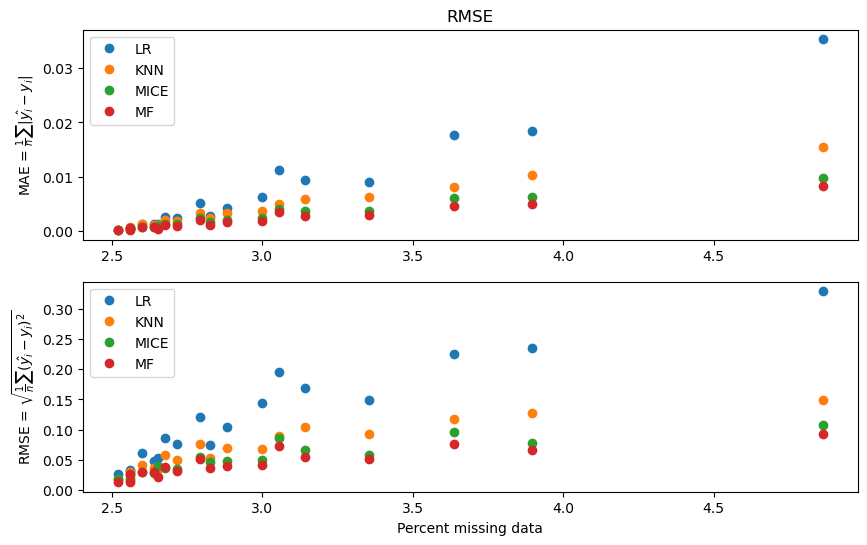

In [10]:
fig, ax = plt.subplots(2, 1, figsize=(10, 6))

methods = ['LR', 'KNN', 'MICE', 'MF']
for i, method in enumerate(methods):

    ax[0].plot(performance[method]['MAE']['x'], performance[method]['MAE']['y'],'o', label=method)
    ax[0].legend()
    ax[0].set_ylabel(r'MAE = $\frac{1}{n}\sum|\hat{y_i} - y_i|$')
    ax[0].set_title('MAE')

    ax[1].plot(performance[method]['RMSE']['x'], performance[method]['RMSE']['y'],'o', label=method)
    ax[1].legend()
    ax[1].set_ylabel(r'RMSE = $\sqrt{\frac{1}{n}\sum(\hat{y_i} - y_i)^2}$')
    ax[1].set_xlabel('Percent missing data')
    ax[0].set_title('RMSE')
    
plt.show()

# Determine hyperparameter n for KNN

In [89]:
method = 'KNN'
gap_type = 'continuous'

metrics_MAE = []
metrics_RMSE = []
metrics_n = []
            
for n in tqdm([2,3,5,7,9,11,13,15,19]):
    params = {'n_estimators': 10,
              'max_iter' : 10,
              'n_neighbors' : n}
    
    method = f'KNN_{n}'
    
    p = 56 # gap length
    q = 24 # number of sites that have missing data
           
    run_experiment(gap_type=gap_type, p=p, q=q, method=method, params=params)

    # calculate errors
    suffix = f'_{gap_type}_{p}_{q}_{method}'
    
    with open(f'gaps_{gap_type}_{p}_{q}.yaml') as file:
        metadata = yaml.safe_load(file)

    missing_data = metadata['missing']
        
    O = pd.read_csv(f'obs{suffix}.csv', index_col=0)
    S = pd.read_csv(f'sim{suffix}.csv', index_col=0)
    
    error = O - S
    MAE = np.mean(abs(error))
    RMSE = np.sqrt(np.mean((error)**2))

    metrics_n.append(n)
    metrics_MAE.append(MAE)
    metrics_RMSE.append(RMSE)
       

  0%|          | 0/9 [00:00<?, ?it/s]

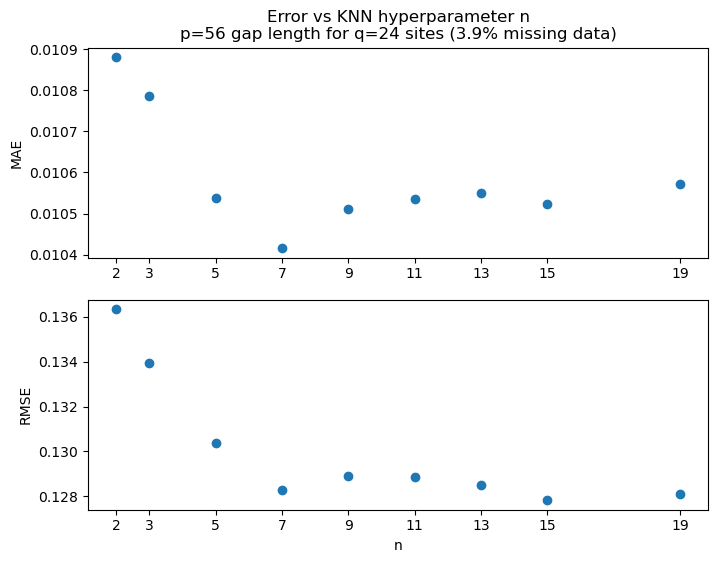

In [93]:
fig, ax = plt.subplots(2, 1, figsize=(8, 6))

ax[0].set_title(f'Error vs KNN hyperparameter n\np={p} gap length for q={q} sites ({missing_data:.1f}% missing data)')
ax[0].plot(metrics_n, metrics_MAE, 'o')
ax[0].set_xticks(metrics_n)
ax[0].set_ylabel('MAE')
ax[1].plot(metrics_n, metrics_RMSE, 'o')
ax[1].set_ylabel('RMSE')
ax[1].set_xlabel('n')
ax[1].set_xticks(metrics_n)

plt.show()

# Iterations of MICE

In [133]:
method = 'MICE'
gap_type = 'continuous'

metrics_MAE = []
metrics_RMSE = []
metrics_n = []
            
for n in tqdm([1, 2, 3, 4, 5, 6]):
    params = { 'n_iterations' : n }
    
    method = f'MICE_{n}'
    
    p = 56 # gap length
    q = 24 # number of sites that have missing data
           
    run_experiment(gap_type=gap_type, p=p, q=q, method=method, params=params)

    # calculate errors
    suffix = f'_{gap_type}_{p}_{q}_{method}'
    
    with open(f'gaps_{gap_type}_{p}_{q}.yaml') as file:
        metadata = yaml.safe_load(file)

    missing_data = metadata['missing']
        
    O = pd.read_csv(f'obs{suffix}.csv', index_col=0)
    S = pd.read_csv(f'sim{suffix}.csv', index_col=0)
    
    error = O - S
    MAE = np.mean(abs(error))
    RMSE = np.sqrt(np.mean((error)**2))

    metrics_n.append(n)
    metrics_MAE.append(MAE)
    metrics_RMSE.append(RMSE)
       

  0%|          | 0/6 [00:00<?, ?it/s]

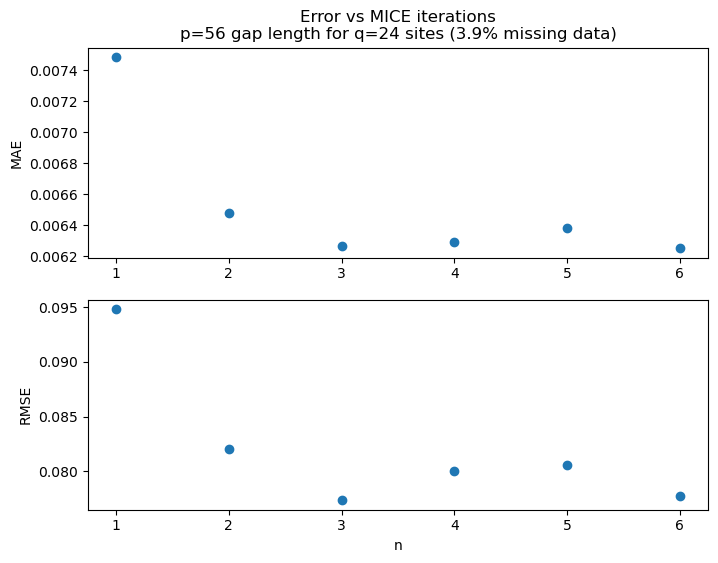

In [135]:
fig, ax = plt.subplots(2, 1, figsize=(8, 6))

ax[0].set_title(f'Error vs MICE iterations\np={p} gap length for q={q} sites ({missing_data:.1f}% missing data)')
ax[0].plot(metrics_n, metrics_MAE, 'o')
ax[0].set_xticks(metrics_n)
ax[0].set_ylabel('MAE')
ax[1].plot(metrics_n, metrics_RMSE, 'o')
ax[1].set_ylabel('RMSE')
ax[1].set_xlabel('n')
ax[1].set_xticks(metrics_n)

plt.show()

# MissForest

In [44]:
method = 'MF'
gap_type = 'continuous'

metrics_MAE = []
metrics_RMSE = []
metrics_n = []

from lightgbm import LGBMClassifier
from lightgbm import LGBMRegressor

for n in tqdm([50, 100]):

    
    lgbm_clf = LGBMClassifier(verbosity=-1, linear_tree=True)
    lgbm_rgr = LGBMRegressor(n_estimators=n, num_leaves=10, n_jobs=-1)

    params = { 'clf' : lgbm_clf,
               'rgr' : lgbm_rgr,
               'verbose' : 1}
    
    method = f'MF_{n}'
    
    p = 56 # gap length
    q = 24 # number of sites that have missing data
           
    run_experiment(gap_type=gap_type, p=p, q=q, method=method, params=params)

    # calculate errors
    suffix = f'_{gap_type}_{p}_{q}_{method}'
    
    with open(f'gaps_{gap_type}_{p}_{q}.yaml') as file:
        metadata = yaml.safe_load(file)

    missing_data = metadata['missing']
        
    O = pd.read_csv(f'obs{suffix}.csv', index_col=0)
    S = pd.read_csv(f'sim{suffix}.csv', index_col=0)
    
    error = O - S
    MAE = np.mean(abs(error))
    RMSE = np.sqrt(np.mean((error)**2))

    metrics_n.append(n)
    metrics_MAE.append(MAE)
    metrics_RMSE.append(RMSE)


print(metrics_MAE)
print(metrics_RMSE)

  0%|          | 0/2 [00:00<?, ?it/s]


%|                                                                                             | 0/5 [00:00<?, ?it/s]
%|█████████████████                                                                    | 1/5 [00:01<00:07,  1.88s/it]
%|██████████████████████████████████                                                   | 2/5 [00:09<00:16,  5.54s/it]
%|███████████████████████████████████████████████████                                  | 3/5 [00:11<00:07,  3.81s/it]
%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:13<00:03,  3.03s/it]
100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:15<00:00,  3.17s/it]

%|                                                                                             | 0/5 [00:00<?, ?it/s]
%|█████████████████                                                                    | 1/5 [00:00<00:00,  5.56it/s]
%|██████████████████████████████████               

[np.float64(0.04678744403555116), np.float64(0.05632998990049824)]
[np.float64(0.5353602806078334), np.float64(0.6057448778297323)]


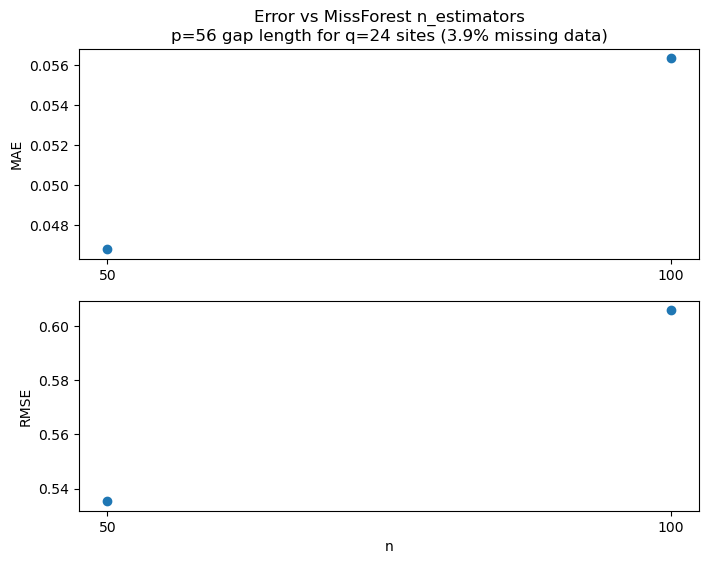

In [45]:
fig, ax = plt.subplots(2, 1, figsize=(8, 6))

ax[0].set_title(f'Error vs MissForest n_estimators\np={p} gap length for q={q} sites ({missing_data:.1f}% missing data)')
ax[0].plot(metrics_n, metrics_MAE, 'o')
ax[0].set_xticks(metrics_n)
ax[0].set_ylabel('MAE')
ax[1].plot(metrics_n, metrics_RMSE, 'o')
ax[1].set_ylabel('RMSE')
ax[1].set_xlabel('n')
ax[1].set_xticks(metrics_n)

plt.show()

In [29]:
performance = {}
gap_types = ['continuous']

for gap_type in gap_types:

    performance[gap_type] = { 'R2': {}, 'PBIAS': {}, 'KGE': {} }
    
    for q in [12, 24]:
        for p in [7, 14, 21, 35]:
            for method in ['LR', 'KNN']:
                suffix = f'_{gap_type}_{p}_{q}_{method}'

                O = pd.read_csv(f'obs{suffix}.csv', index_col=0)
                S = pd.read_csv(f'sim{suffix}.csv', index_col=0)
                
                results = gof(S, O)
        
                position = f'{p}_{q} {method}'
                performance[gap_type]['R2'][position] = results['R2']
                performance[gap_type]['PBIAS'][position] = results['PBIAS']
                performance[gap_type]['KGE'][position] = results['KGE']
        
    for metric in ['R2', 'PBIAS', 'KGE']:
        performance[gap_type][metric] = pd.DataFrame(performance[gap_type][metric])

2211
450
2211
0
2211
450
2211
0
2211
450
2211
0
2211
458
2211
0
2211
450
2211
0
2211
450
2211
0
2211
450
2211
0
2211
458
2211
0


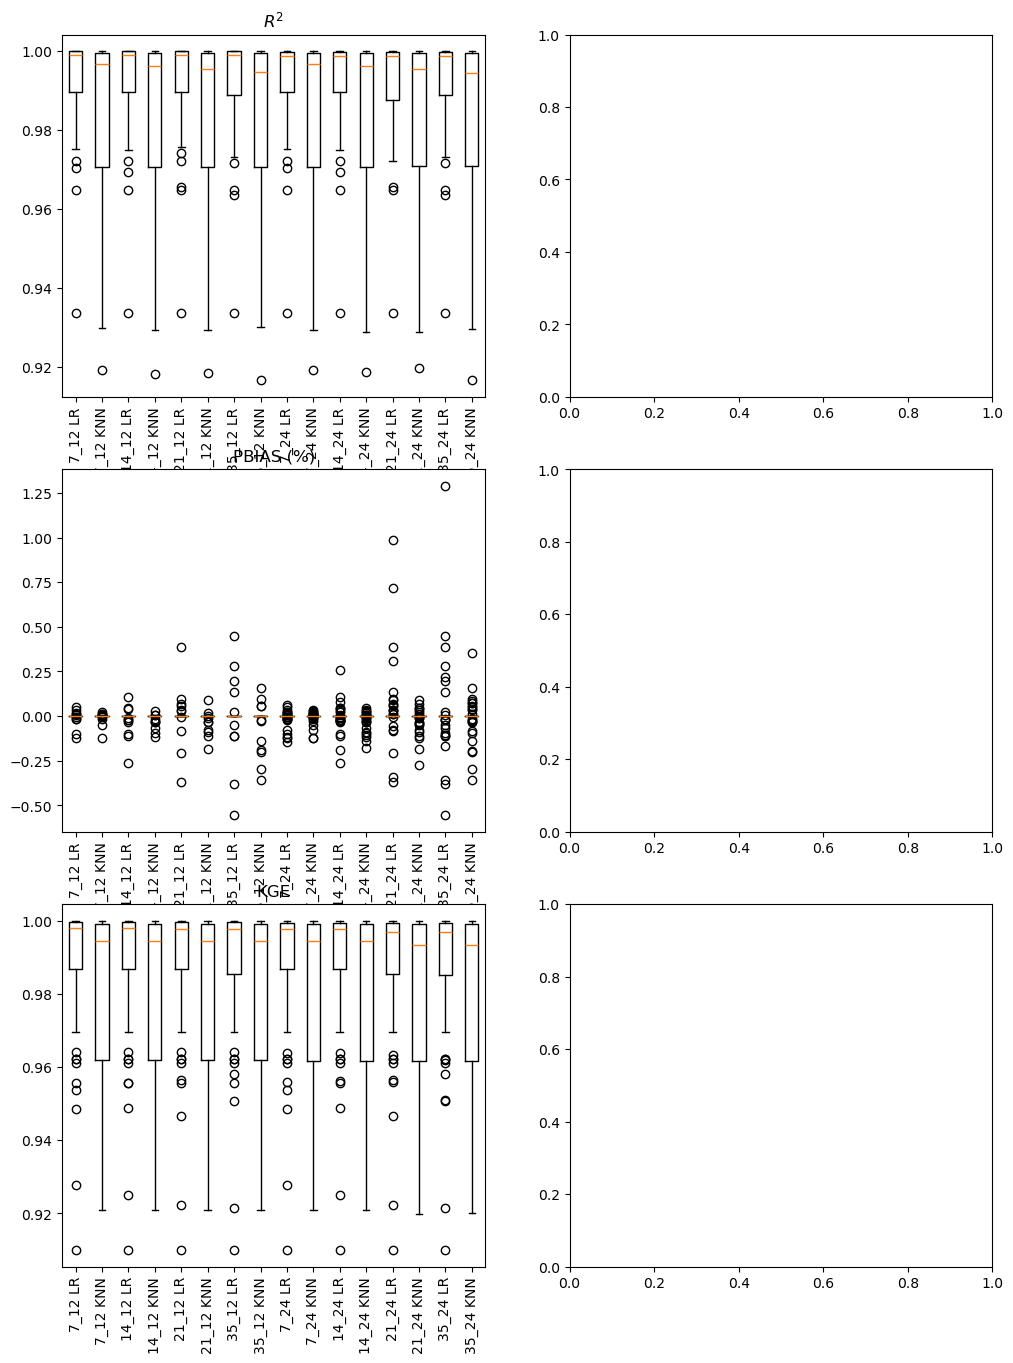

In [21]:
fig, ax = plt.subplots(3, 2, figsize=(12, 16))

for i, gap_type in enumerate(gap_types):
    labels = list(performance[gap_type]['R2'].columns)
    
    ax[0,i].boxplot(performance[gap_type]['R2'])
    ax[0,i].set_xticklabels(labels, rotation=90)
    ax[0,i].set_title('$R^2$')

    ax[1,i].boxplot(performance[gap_type]['PBIAS'])
    ax[1,i].set_xticklabels(labels, rotation=90)
    ax[1,i].set_title('PBIAS (%)')

    ax[2,i].boxplot(performance[gap_type]['KGE'])
    ax[2,i].set_xticklabels(labels, rotation=90)
    ax[2,i].set_title('KGE')
    
plt.show()